# Imports

In [0]:
import time
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score

%matplotlib inline  
import matplotlib.pyplot as plt

In [0]:
# Make sure we are using a GPU if it is available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Gather data

In [2]:
# Download image data of bees and ants.
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-05-14 22:12:30--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.227.223.82, 13.227.223.15, 13.227.223.75, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.223.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  77.7MB/s    in 0.6s    

2020-05-14 22:12:30 (77.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
# unzip the data.
! unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

# Pre-process the data

In [0]:
# We are going to use the PyTorch dataloaders that we previously introduced
# along with some convenience functions from torchvision to pre-process our
# image data.

# These data transforms will tell the PyTorch how to transform the data
# as it is imported. We will resize all of our images to the size of images
# used in ResNet18.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
# The directory where our data lives.
data_dir = 'hymenoptera_data'

# Use torchvision to load our images into memory, label them, and transform them.
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Create train and test data loaders.
train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=True, num_workers=4)

# Gather some info about the datasets.
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}
class_names = train_dataset.classes

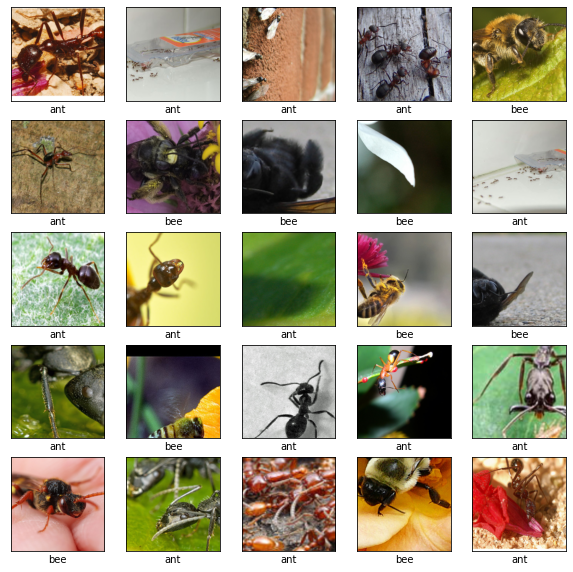

In [36]:
# Take a look at some of our images and the corresponding labels.
plt.figure(figsize=(10,10))
for i in range(25):
  inputs, classes = next(iter(train_loader))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  sample = inputs[0].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  sample = std * sample + mean
  sample = np.clip(sample, 0, 1)
  plt.imshow(sample)
  if classes[0].item() == 0:
    plt.xlabel('ant')
  else:
    plt.xlabel('bee')

# Load the pre-trained model and modify the classification head only

In [0]:
# Load the pre-trained resnet18 model.
model = torchvision.models.resnet18(pretrained=True)

# "freeze" the convolutional parameters.
for param in model.parameters():
    param.requires_grad = False

# Determine the input dimension for the FC classification layer in ResNet18.
num_ftrs = model.fc.in_features

# Modify the model to output predictions for only two labels rather than 1000.
model.fc = nn.Linear(num_ftrs, 2)

In [0]:
# Our error/loss function. 
criterion = nn.CrossEntropyLoss()

# Define our optimizer to only optimize the FC layer parameters.
optimiser = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

# Make sure the model will to loaded into the GPU for training.
model = model.to(device)

# Train the model

In [47]:
# loop over our epochs
loss_values = []
for epoch in range(10):

  running_loss = 0.0
  for i, (features, labels) in enumerate(train_loader):

    # clear the gradients
    optimiser.zero_grad()

    # calculate the predicted values
    predictions = model(features)

    # calculate our loss
    loss = criterion(predictions, labels)
    running_loss += loss.item()

    # implement our gradient-based updates to our
    # parammeters (putting them "back" into the model
    # via a "backward" update)
    loss.backward()
    optimiser.step()

  # Print some info
  loss_values.append(running_loss/30.)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, running_loss/32.))

Epoch: 1 	Training Loss: 1.426230
Epoch: 2 	Training Loss: 1.297806
Epoch: 3 	Training Loss: 1.244716
Epoch: 4 	Training Loss: 1.220210
Epoch: 5 	Training Loss: 1.130642
Epoch: 6 	Training Loss: 1.112226
Epoch: 7 	Training Loss: 1.042472
Epoch: 8 	Training Loss: 1.018280
Epoch: 9 	Training Loss: 0.942296
Epoch: 10 	Training Loss: 0.909980


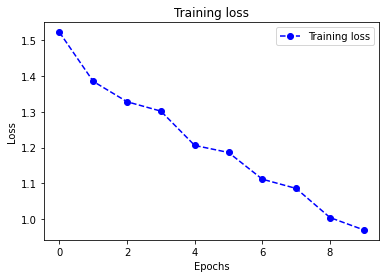

In [50]:
# Plot the training loss for each epoch to see how the model converged.
plt.plot(range(10), loss_values, 'bo--', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Evaluate the model

In [63]:
predictions = []
observations = []
with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        out = model(features)
        _, pred_idx = torch.max(out.data, 1)
        obs_idx = [x.item() for x in labels.data]
        labels = ['ant', 'bee']
        for idx, p in enumerate(pred_idx):
            predictions.append(labels[p])
            observations.append(labels[obs_idx[idx]])

# Calculate accuracy
acc = accuracy_score(observations, predictions)
print('Accuracy: ', acc)

Accuracy:  0.7973856209150327
